<h1 align='center'> Sentiment Analysis

In [57]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


#Preprocessing libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from contractions import CONTRACTION_MAP #Importing contractions script
import unicodedata
import re

#Vectorizer library.
from keras.preprocessing.text import text_to_word_sequence,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, HashingVectorizer

#evaluation matrices library
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score

#LSTM Model
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

from sklearn.feature_selection import chi2

#visulaization:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
filename = 'Twitter_Data.csv'
analysis_df = pd.read_csv(filename,encoding='latin1',usecols=['text','sentiment'])

In [3]:
analysis_df.head()

,text,sentiment
0,when modi promised âminimum government maxim...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [4]:
# convert the sentiments to numeric data.
def ConvertSentiments(_sentiment):
    cvt_sentiment = 0
    if _sentiment == 1:
        cvt_sentiment = 2
    elif _sentiment == 0:
        cvt_sentiment = 1
    else:
        cvt_sentiment = 0
        
    return cvt_sentiment

In [5]:
analysis_df['C_Sentiment'] = analysis_df.sentiment.apply(ConvertSentiments)

In [6]:
print(analysis_df.shape)
analysis_df.head()

(162951, 3)


,text,sentiment,C_Sentiment
0,when modi promised âminimum government maxim...,-1.0,0
1,talk all the nonsense and continue all the dra...,0.0,1
2,what did just say vote for modi welcome bjp t...,1.0,2
3,asking his supporters prefix chowkidar their n...,1.0,2
4,answer who among these the most powerful world...,1.0,2


In [7]:
analysis_df['text'] = analysis_df['text'].astype('category')
analysis_df['C_Sentiment'] = analysis_df['C_Sentiment'].astype('category')
analysis_df['sentiment'] = analysis_df['sentiment'].astype('category')

In [8]:
analysis_df.dtypes

text           category
sentiment      category
C_Sentiment    category
dtype: object

In [9]:
#converting tweets into lower:
analysis_df['text'] = [str(tweets).strip().lower() for tweets in analysis_df['text']]

In [10]:
analysis_df.head()

,text,sentiment,C_Sentiment
0,when modi promised âminimum government maxim...,-1.0,0
1,talk all the nonsense and continue all the dra...,0.0,1
2,what did just say vote for modi welcome bjp t...,1.0,2
3,asking his supporters prefix chowkidar their n...,1.0,2
4,answer who among these the most powerful world...,1.0,2


In [11]:
#Text Preprocessing
#Contractions:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


#Scrub word removal:
def scrub_words(text):
    #Replace \xao characters in text
    text = re.sub('\xa0', ' ', text)
    
    #Replace non ascii / not words and digits
    text = re.sub("(\\W|\\d)",' ',text)
    
    #Replace new line characters and following text untill space
    text = re.sub('\n(\w*?)[\s]', '', text)
    
    #Remove html markup
    text = re.sub("<.*?>", ' ', text)
    return text

#Creating function object to convert ASCII character
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [12]:
analysis_df['text'] = analysis_df.text.apply(expand_contractions)

In [13]:
analysis_df['text'] = analysis_df.text.apply(scrub_words)

In [14]:
analysis_df['text'] = analysis_df.text.apply(remove_accented_chars)

In [15]:
analysis_df.head()

,text,sentiment,C_Sentiment
0,when modi promised a minimum government maxim...,-1.0,0
1,talk all the nonsense and continue all the dra...,0.0,1
2,what did just say vote for modi welcome bjp t...,1.0,2
3,asking his supporters prefix chowkidar their n...,1.0,2
4,answer who among these the most powerful world...,1.0,2


In [16]:
# stopwords:
stopWords = stopwords.words('english')
#add extra stop word
extra_stopWords = ['na','rt','http']
stopWords.extend(extra_stopWords)

In [17]:
print(stopWords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
# Tokenization and Stop word removal.
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def Tokenizer_SWR_SL(_text, isLemamtize = False):
    tweets = text_to_word_sequence(_text)
    if isLemamtize:
        tweets = [lemmatizer.lemmatize(word) for word in tweets if not word in stopWords]
    else:
        tweets = [stemmer.stem(word) for word in tweets if not word in stopWords]    
    tweets = ' '.join(tweets)
    
    return tweets

In [19]:
analysis_df['text'] = analysis_df.text.apply(Tokenizer_SWR_SL,True)
analysis_df.head()

,text,sentiment,C_Sentiment
0,modi promis minimum govern maximum governancea...,-1.0,0
1,talk nonsens continu drama vote modi,0.0,1
2,say vote modi welcom bjp told rahul main campa...,1.0,2
3,ask support prefix chowkidar name modi great s...,1.0,2
4,answer among power world leader today trump pu...,1.0,2


In [20]:
tokenized_tweet  = analysis_df.text.apply(lambda x: text_to_word_sequence(x))
print(tokenized_tweet [0:5])

0    [modi, promis, minimum, govern, maximum, gover...
1          [talk, nonsens, continu, drama, vote, modi]
2    [say, vote, modi, welcom, bjp, told, rahul, ma...
3    [ask, support, prefix, chowkidar, name, modi, ...
4    [answer, among, power, world, leader, today, t...
Name: text, dtype: object


In [21]:
import gensim
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [23]:
def FindMaxLength(_tweet_seq):
    tweet_length = []
    for tweet in _tweet_seq:
        tweet_length.append(len(tweet))
    return max(tweet_length)     

In [24]:
#Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_tweet)
tweet_seq = tokenizer.texts_to_sequences(tokenized_tweet)

In [26]:
validation_split = 0.3
max_length = FindMaxLength(tweet_seq)

In [27]:
word_index = tokenizer.word_index
print(f"unique tokens - {len(word_index)}")
vocab_size = len(tokenizer.word_index) + 1
print(f'vocab_size - {vocab_size}')

lines_pad = pad_sequences(tweet_seq, maxlen=max_length, padding='post')
category =  analysis_df['C_Sentiment'].values

unique tokens - 84521
vocab_size - 84522


In [29]:
#Example for padded tweet.
lines_pad[0]

array([    1,    54,   699,    27,  1533, 17302,   271,   896,  1093,
          55,  1207,   115,    28,    14,    21,   995,   115,   265,
        3011,  2652,  1106,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [32]:
lines_pad.shape

(162951, 59)

#### Train and Test split

In [34]:
indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices] # Shuffled form of attributes
category = category[indices] # Shuffled form of target variables

n_values = max(category) + 1
Y = np.eye(n_values)[category]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = Y[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = Y[-num_validation_samples:]

In [37]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (114066, 59)
Shape of y_train: (114066, 3)
Shape of X_test_pad: (48885, 59)
Shape of y_test: (48885, 3)


## Word2Vec

In [43]:
embedding_dim = 300
word2vec_dir = "D:\Word2Vec\PretrainedModel"
from gensim.models import KeyedVectors
word2vec_model = KeyedVectors.load_word2vec_format(os.path.join(word2vec_dir,'GoogleNews-vectors-negative300.bin'), binary=True)

In [44]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model: 
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector

In [45]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [46]:
model_word2vec = Sequential()
model_word2vec.add(embedding_layer)
model_word2vec.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
model_word2vec.add(Dense(3, activation='softmax'))

model_word2vec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_word2vec.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 59, 300)           25356600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 25,399,323
Trainable params: 42,723
Non-trainable params: 25,356,600
_________________________________________________________________
None


In [51]:
checkpoint = ModelCheckpoint('LSTM-SentimentModel.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')

In [52]:
history_word2vec = model_word2vec.fit(X_train_pad, y_train, batch_size=32, epochs=10, validation_data=(X_test_pad, y_test), callbacks=[checkpoint], verbose=1)

Train on 114066 samples, validate on 48885 samples
Epoch 1/10
114066/114066 [==============================] - 116s 1ms/step - loss: 0.6799 - accuracy: 0.7191 - val_loss: 0.6287 - val_accuracy: 0.7439

Epoch 00001: val_accuracy improved from -inf to 0.74389, saving model to LSTM-SentimentModel.h5
Epoch 2/10
114066/114066 [==============================] - 115s 1ms/step - loss: 0.6428 - accuracy: 0.7390 - val_loss: 0.6019 - val_accuracy: 0.7632

Epoch 00002: val_accuracy improved from 0.74389 to 0.76316, saving model to LSTM-SentimentModel.h5
Epoch 3/10
114066/114066 [==============================] - 115s 1ms/step - loss: 0.6134 - accuracy: 0.7551 - val_loss: 0.5830 - val_accuracy: 0.7722

Epoch 00003: val_accuracy improved from 0.76316 to 0.77220, saving model to LSTM-SentimentModel.h5
Epoch 4/10
114066/114066 [==============================] - 115s 1ms/step - loss: 0.5945 - accuracy: 0.7671 - val_loss: 0.5625 - val_accuracy: 0.7848

Epoch 00004: val_accuracy improved from 0.77220 to 

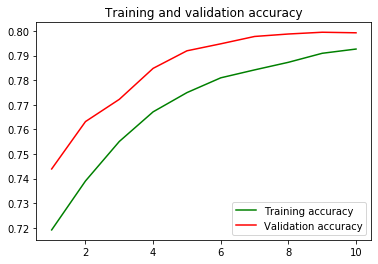

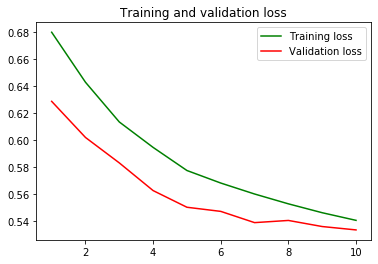

In [55]:
# Plot results
import matplotlib.pyplot as plt

acc = history_word2vec.history['accuracy']
val_acc = history_word2vec.history['val_accuracy']
loss = history_word2vec.history['loss']
val_loss = history_word2vec.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [56]:
test_pred = model_word2vec.predict_classes(X_test_pad)

In [81]:
print(len(test_pred))
test_pred

48885


array([0, 2, 1, ..., 1, 1, 0], dtype=int64)

In [82]:
test_act = [np.argmax(data) for data in y_test]
print(len(test_act))

48885


In [83]:
f1_score(test_act,test_pred,average='macro')

0.7833817773375852

In [85]:
accuracy_score(test_act,test_pred)

0.7992635777845966